# JCG Analysis
* Last Update: 24-Sep-2022
* Expansion: Roar of Godwyrm Mini

## Introduction
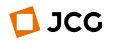

**[JCG Shadowverse Open](https://sv.j-cg.com/)** is a popular tournament series that can provide valuable insights to the Shadowverse meta in the 2 Deck 0 Ban format. Rotation is the most organized tournament, followed by Unlimited and Take Two. The scope of this analysis will be limited to **Rotation**. In this notebook, the libraries `pandas` and `BeautifulSoup` will be primarily used. I highly suggest reading up on these two libraries or looking for answers actively to fit your needs like I did. The browser I am using to explore the JCG website is **Google Chrome**.

### Breakdown of a JCG tournament
- Every tournament has a maximum of 256 players, but the number of registrants can exceed 256. 
- In the event where there are too many players, a lottery will be held to decide the lucky 256 who will be playing while the rest will not. 
- The players will be divided into 16 groups of maximum 16 players each (予選). A single elimination format will be played and the winner of each group (予選) will proceed to the finals (決勝). 
- The final 16 will once again play in a single elimination tournament to decide the champion of that JCG volume. 
- In the event that any of the final 16 players is unable to play in the finals, the 2nd place player of that player will take up the spot instead.

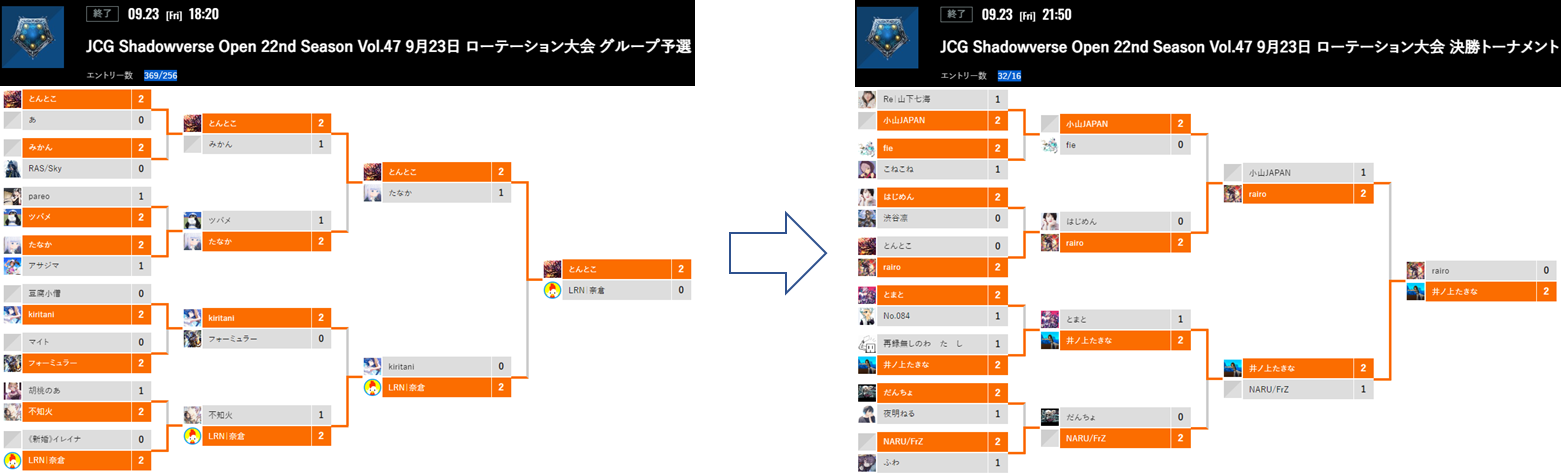

In [92]:
## Import the libraries
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import xlsxwriter

# ## Import hashfiles of card
# cardhash_df = pd.read_excel("C:\\Users\\winso\\Documents\\PythonFiles\\SV_Finalysis_2022\\00_URLcode_ROTGmini.xlsx", sheet_name="00")
# cardhash_dict = cardhash_df.set_index("Code")["Name"].to_dict()

## Exploring the JCG Shadowverse Open website
We will briefly explore the [site](https://sv.j-cg.com/) to decide where to scrape our data from. A translator tool like DeepL would be useful.

### Past Schedule

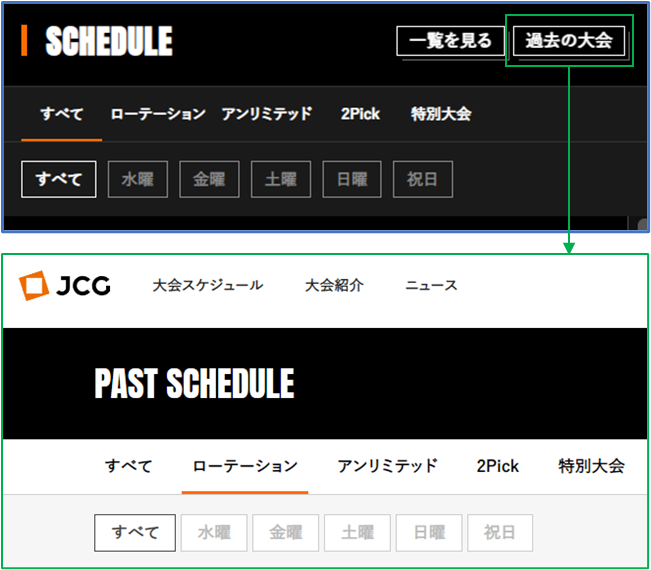

Navigate to the schedule page and filter to the Rotation format. Here we can see a list of past tournaments. Note that ongoing tournaments will not show here.

**Right-click > Inspect** to bring up the console. We can take a look at the html to see how the elements are constructed.

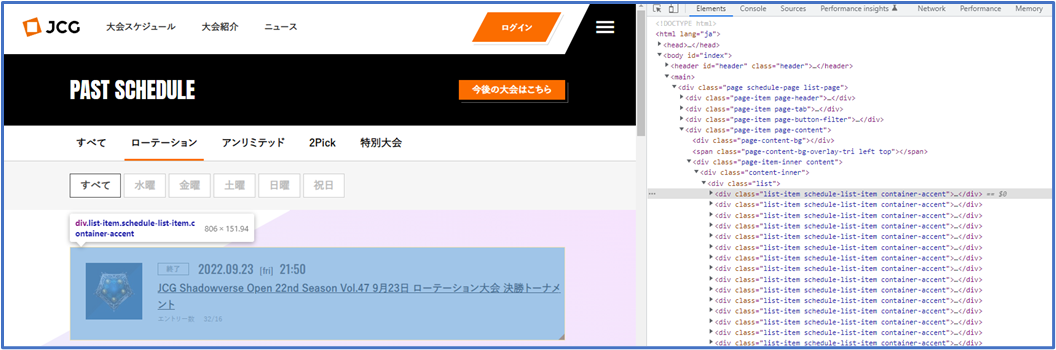

After hovering and playing around, we can see that the tournament information is contained within `<div class="content-inner">`. We can scrape the information of all tournament here rather than going into individual tournament webpages. If we expand `<div class="list-item schedule-list-item container-accent">` we can further see the information such as the href hyperlink, tournament link, participants, etc.

Scrape them using `BeautifulSoup` and `pandas` to store the information into a DataFrame.

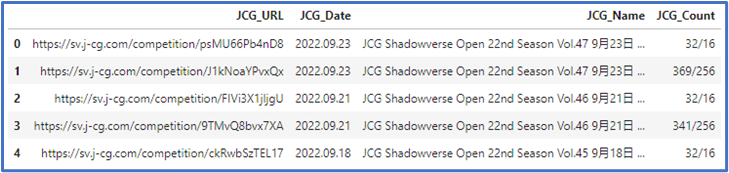

In [93]:
## Store target URL. schedule_url refers to the JCG past-schedule page for rotation. Does not capture ongoing tournaments.
schedule_url = f'https://sv.j-cg.com/past-schedule/rotation?page=1'
## Make a GET request to access URL.
sch_result = requests.get(schedule_url)
## Check if we obtain a 200, to verify that page is indeed present. 
print(sch_result.status_code) if (sch_result.status_code == 200) else print(f"Page not accessible, {sch_result.status_code}")
## Store the URL source in a variable, src is a messy pile.
sch_src = sch_result.content
## Use BeautifulSoup object to parse and process the source.
sch_soup = BeautifulSoup(sch_src)

## From page of past-schedule, scrape all tournaments. Store into a ResultSet
sch_resultset = sch_soup.find_all("a", attrs={"class":"schedule-link"})
## Iterate ResultSet, and retrieve the text of key data. 
sch_list = [[each["href"], each.find("div", attrs={"class":"schedule-date"}).text.split("\n")[0],
                         each.find("div", attrs={"class":"schedule-title"}).text,
                         each.find("div", attrs={"class":"schedule-entry-count"}).text.split("数 ")[1].replace("\n","")] 
                        for each in sch_resultset]
## Create a DataFrame and store all information of scraped tournaments. 
sch_df = pd.DataFrame(sch_list, columns = ["JCG_URL", "JCG_Date", "JCG_Name", "JCG_Count"])
## Preview the latest 5 tournaments
# sch_df.head(5)

200


### Tournament Page

This is the part where we're interested; finding the winners, and the decks brought by participants. 

> Each tournament has a unique "code" after https://sv.j-cg.com/competition/, for example https://sv.j-cg.com/competition/J1kNoaYPvxQx/

> Adding /home, /entries, /bracket, /results will bring you to the different pages. 

#### Participant List 参加者一覧
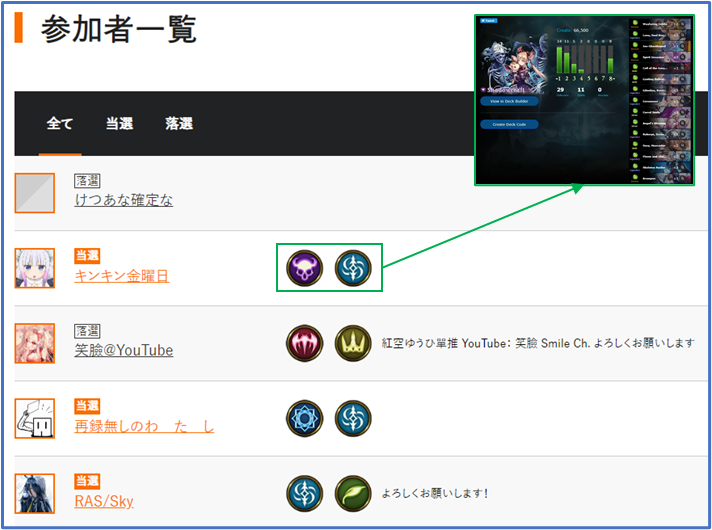

[Example](https://sv.j-cg.com/competition/J1kNoaYPvxQx/entries)

This page contains the list of all registrants. On closer look we can see who are playing in the tournament (当選) and who lost the lottery (落選 i.e. not playing).
Most registrants would have two registered decks that are publicly available. Each deck is represented by the corresponding class logo that links to the shadowverse-portal decklist page when clicked. 

**Right-click > Inspect** to bring up the console. We can take a look at the html to see how the elements are constructed.

We can see that the player information is contained within `<div class="competition-content-item main competition-entries">`. Notice that this time we see a `<script>` containter that contains a lot of hashes that resembles Shadowverse cards.

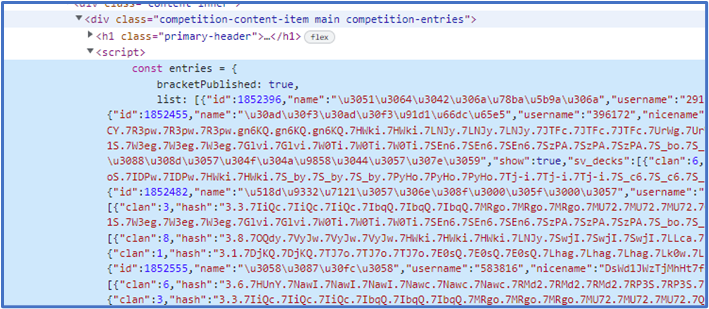

We can first use `BeautifulSoup` to get the raw text of this portion. When we use `print(jcg_text)`, we see that there is a dictionary/json that we can work with. After using string slicing and replacing special characters, we can create a json that we can parse into a DataFrame to work with.

In [94]:
## Store target URL. 
jcg_url = sch_df["JCG_URL"][1]
## Make a GET request to access URL.
jcg_result = requests.get(f"{jcg_url}/entries")
## Check if we obtain a 200, to verify that page is indeed present. 
print(jcg_result.status_code) if (jcg_result.status_code == 200) else print(f"Page not accessible, {jcg_result.status_code}")
## Store the URL source in a variable, src is a messy pile.
jcg_src = jcg_result.content
## Use BeautifulSoup object to parse and process the source.
jcg_soup = BeautifulSoup(jcg_src)

200


In [95]:
## Retrieve the raw string containing info of all decks.
jcg_text = jcg_soup.find("div", attrs={"class":"competition-content-item main competition-entries"}).find("script").text
## Use string slicing to retrieve only the decks. Replace and strip unnecessary text and special characters.
jcg_str = jcg_text[jcg_text.find("list"):jcg_text.find(",\n        listFiltered:")].replace("list: ","")
## Parse the string with a json format (list of dicts), and then create a DataFrame 
jcg_rawdf = pd.DataFrame(json.loads(jcg_str))

#### Tasks

We now have a "raw" extract to work with. Further cleaning is required in order to filter our irrelevant details (i.e. we only want the 256 players).

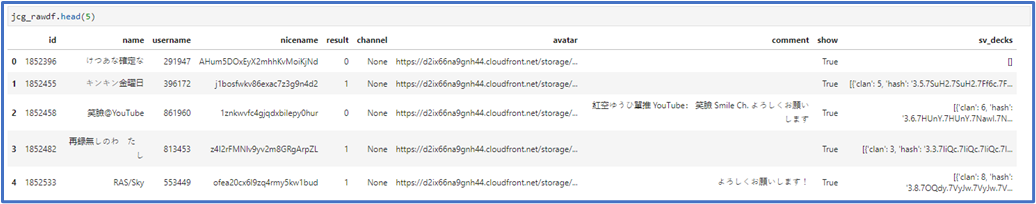

| **_Column_** 	| **_Definition_**                                                                                     	|
|--------------	|------------------------------------------------------------------------------------------------------	|
| **id**       	| Unique ID of player in the tournament.                                                               	|
| **name**     	| Registered name of player in the tournament. <br>This is **non-unique**, the famous example being numerous あ in a tournament.                                                         	|
| **username** 	| Unique User ID of an account in JCG. <br>Example: ユーザーID is 350559 in https://sv.j-cg.com/user/5lpZwSdLvUOSau7TWHx2citN                           	|
| **nicename** 	| Unique URL code of an account in JCG. <br>Example: **5lpZwSdLvUOSau7TWHx2citN** --> https://sv.j-cg.com/user/5lpZwSdLvUOSau7TWHx2citN 	|
| **result**   	| 0:落選 (Not Playing), <br>1: 当選 (Playing)                                                             	|
| **channel**  	| None, not sure                                                                                       	|
| **avatar**   	| Display picture of player                                                                            	|
| **comment**  	| Flavor text/info of players                                                                          	|
| **show**     	| Not sure                                                                                             	|
| **sv_decks** 	| List of dictionary containing Shadowverse decks                                                      	|


Here are some goals that I want to achieve:
- To identify players by their username or nicename, since there are too many あ in tournaments which may cause identification issues.
- To convert sv_decks into workable shadowverse-portal URLs.

In [96]:
## 1. Filter out actual participants. (i.e. Players who won the lottery and are part of the 256 players)
jcg_rawdf = jcg_rawdf.loc[jcg_rawdf['result']==1]
## 2. Create URL of players' JCG profiles from nicename, an encryption string.
jcg_rawdf["nicename"] = jcg_rawdf["nicename"].apply(lambda x: f"https://sv.j-cg.com/user/{x}")
## 3. Create URL of players' deck from sv_decks. First sort the classes (use sorted which return a value, do not use sort). Then create columns for decks.
jcg_rawdf["sv_decks"] = jcg_rawdf["sv_decks"].apply(lambda x: sorted(x, key = lambda y: y['clan']))
for n in range(2):
    jcg_rawdf[f"Deck{n+1}_URL"] = jcg_rawdf["sv_decks"].apply(lambda x: "https://shadowverse-portal.com/deck/{}?lang=en".format(x[n]["hash"]))
## 4. Remove unnecessary columns. 
jcg_df = jcg_rawdf[["nicename", "name", "Deck1_URL", "Deck2_URL"]].copy().reset_index(drop = True)
## 5. Rename columns, then re-index.
jcg_df.rename(columns = {"name":"Player", "nicename":"PlayerProfile"}, inplace=True)

#### Results Page 大会結果
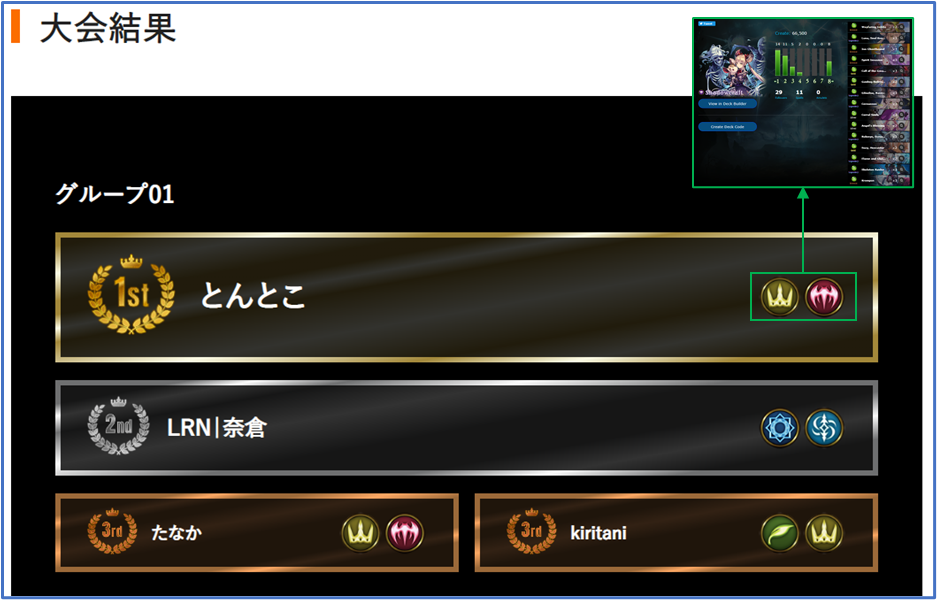

[Example](https://sv.j-cg.com/competition/J1kNoaYPvxQx/results)

This page contains the results of all brackets at the end of the tournament. Similar to Participant List, we can access the winners' decklists by clicking on the class icons.

**Right-click > Inspect** to bring up the console. We can take a look at the html to see how the elements are constructed.

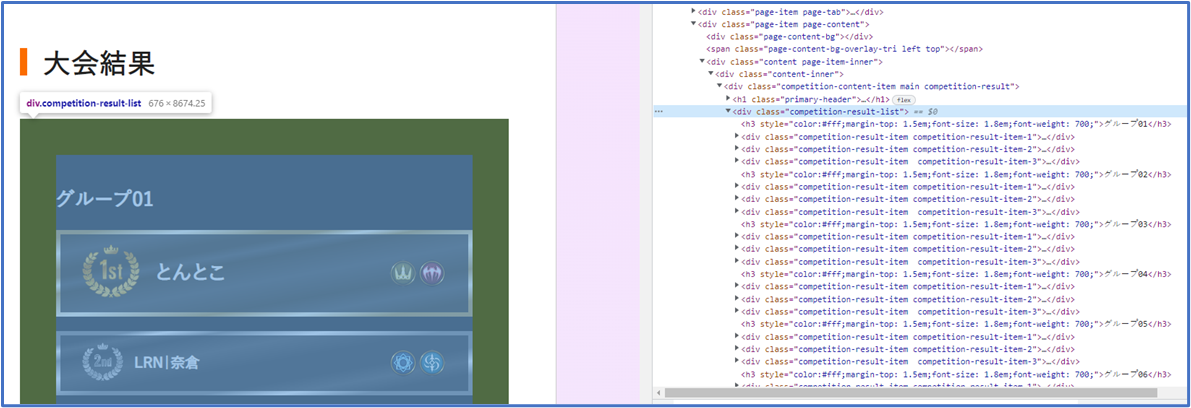

We can see that the winners' information is contained within `<div class="competition-result-list">`. We can follow a similar flow to what we did above for Participant List and gather the list of winners. Since we have already previously gathered the decklist, there is no need to do it here again. We can perform a LEFT JOIN on the `nicename` to get the winning decks.

In [104]:
## Store target URL. 
jcg_res_result = requests.get(f"{jcg_url}/results")
## Check if we obtain a 200, to verify that page is indeed present. 
print(jcg_res_result.status_code) if (jcg_res_result.status_code == 200) else print(f"Page not accessible, {jcg_res_result.status_code}")
## Use BeautifulSoup object to parse and process the source.
jcg_res_result = BeautifulSoup(jcg_res_result.content)

## Retrieve the winners from each group. Scrape all winners, store into a list, and create a DataFrame from the list.
winners_list = []
for n in range(1,4):
    JCG_winners = jcg_res_result.find_all("div", attrs={"class":f"result result-{n}"})
    for each in JCG_winners:
        x = each.find("div", attrs={"class":"result-name"})
        [playerprofile, position] = x.find("a").get("href"), n
        winners_list.append([playerprofile, position])
winners_df = pd.DataFrame(winners_list, columns = ["PlayerProfile", "Pos"])

## Merge the winner's Pos column into the decks df.
jcg_df2 = pd.merge(jcg_df, winners_df, on=["PlayerProfile"], how="left").fillna('-')

200
